# Implementing the Word2Vec Paper

A look at a classic NLP paper

Ibrahim Habib  
2025-04-24

In 2013, the [Efficient Estimation of Word Representations in Vector
Space](https://arxiv.org/abs/1301.3781) paper was released introducing
two new model architectures for generating vector representations (or
embeddings) of words. While today more advanced models are in use, the
Word2vec paper remains a popular classic that has been cited over 40,000
times.

In this post, we will implement the Continous Bag of Words (CBOW) model,
one of the two architectures introduced in the paper. The goal of this
post is to serve as a straightforward example of implementing a paper.

## About Embeddings

Embeddings is a smart technique to encode and represent language. The
problem with traditional one-hot encoding is that it doesn’t carry any
sense of meaning about the captured words. The assignment from words to
vector is arbitrary and relationships and similarities between words are
not captured by the representation.

### One-hot Encoding Problems

I want you to imagine with me the pain of building a model on a
downstream task while representing words with one-hot encoding. Imagine
that we are building a very simple binary classification model that
takes as input a single word and predicts positive or negative sentiment
(a trivial task). This model will pass the one-hot encoded vector to a
single linear layer (note that the argument remains the same for deeper
models). We will consider the deficiency of such representation in two
aspects: quality and cost.

#### Quality

First I want to establish that this model will simply return for each
word in the class which has the most number of occurrences in the
downstream training data. Suppose that the vocab size is 5 and that a
certain word $w$ is represented by the vector $v_w$. Suppose that the
first index of $v_w$ is 1 and the rest are 0.

$$
v_w = [1, 0, 0, 0, 0]
$$

After passing the vector to the linear layer, the output will be:

$$
o = w_1 * 1 + w_2 * 0 + w_3 * 0 + w_4 * 0 + w_5 * 0 + b = w_1 + b
$$

Where $w_i$ is the weight of the $i^{th}$ word in the vocabulary and $b$
is the bias.

To generalize, give a vector $v_w$ of size $n$ where the $i^{th}$ index
is 1 and the rest are 0, the output of the linear layer will be:

$$
o = w_i + b
$$

So basically, the model is memorizing for each and every word it sees
the expected output. No features, no understanding, no learning. It’s
just an expensive lookup table.

Why is that bad? Downstream tasks tend to have much smaller datasets
than the huge language datasets used to build word representations.
Thus, many words will not be seen in the downstream task, and our
*table* will just pick up a random class.

Consider this example which we will revisit later. Suppose that the
downstream dataset contains the word “hunger” and successfully predicts
it as negative. During inference, the model encounters the word “famine”
which is not present in the training data. The model will have no idea
what to do with it and will randomly pick a class. This is a problem
because “famine” is very similar to “hunger” yet the model can’t realize
that.

#### Cost

Continuing with the previous example, let’s assume that the vocabulary
size is 1,000,000. The downstream model will have to learn 1,000,000
weights and 1 bias. The weights increase linearly with the vocabulary
size. This is a disaster as vocabularies are huge. We will see later
that a vector representation can do using less than 1% of the weights
and still achieve better performance.

### Vector Representation

The idea of vector representation is to project every word in the
vocabulary to an $n$-dimensional vector space. This projection is done
such that similar words are close to each other; hence, the location of
the word and the values in the vector carry actual meaning about the
word. This allows us to utilize large amounts of language data to
understand the semantics of words and their relationships, simplifying
any downstream task.

In the previous example, the model is no longer a lookup table but an
actual model with generalization ability that can learn from the encoded
information in the vector. Now, the model will be able to predict the
class of “famine” because its vector is similar to that of “hunger” and
hence will have a close output.

## Summarizing the Paper

The first thing I want to highlight about the paper is its publishing
date: 2013. Computation was expensive, models were small, and
architectures were simple (no transformers yet). So as highlighted in
the name, the goal of the paper is to establish an *efficient* technique
to generate the vector representation.

At the time of publishing, the largest model made was trained on only a
few hundred million words and had a dimensionality of 50-100. Using
their proposed architectures, the authors succeeded in training on 6
billion words and a vector dimensionality of 300.

Two architectures are introduced: Continous Bag-of-Words (CBOW) and
Continous Skip-gram. The CBOW model predicts a token by projecting the
$N$ preceding and the $N$ succeeding token into their vector
representation then summing them, normalizing the sum, and passing it to
a classifier. In their implementation, they used a log-linear classifier
with $N=4$.

The Skip-Gram does the opposite by using a token to predict the
neighboring ones. While training a number $R$ is randomly selected from
the range $<1;C>$ where $C$ is a hyperparameter. The $R$ preceding and
succeeding tokens of the current token are predicted from the current
one.

<figure>
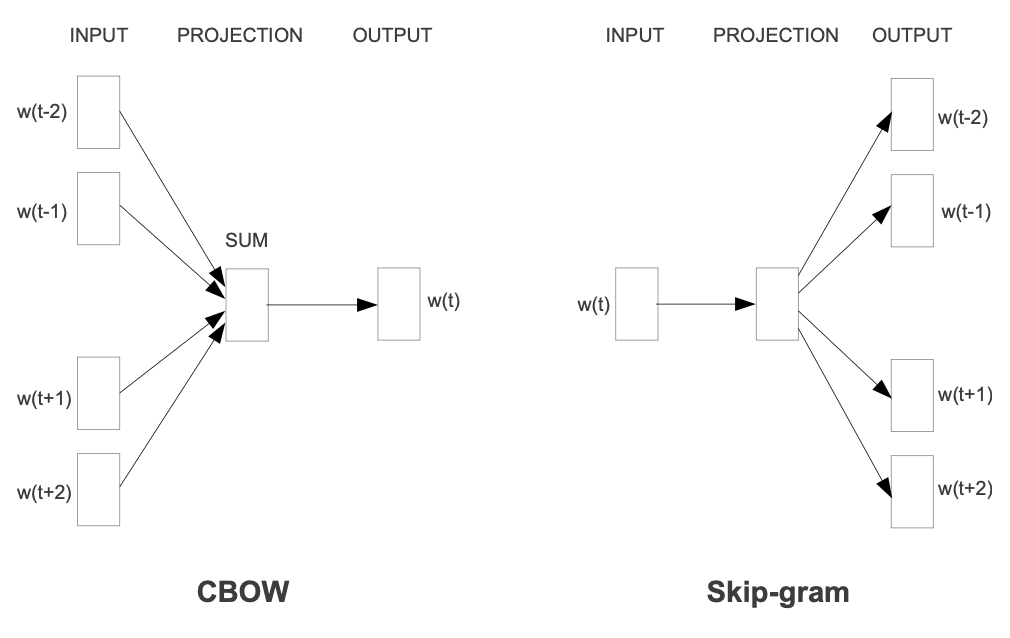
<figcaption aria-hidden="true">CBOW and Skip-gram Architectures from <a
href="https://arxiv.org/abs/1301.3781">the Paper</a></figcaption>
</figure>

To test the quality of the vectors, the authors create a comprehensive
test set containing five types of semantic questions and nine types of
syntactic questions. Each question is represented as two-word pairs. For
example, a *common capital city* question would have word pair 1
$<Athens, Greece>$ and word pair 2 $<Oslo, Norway>$. In this case, the
model will be tested by extracting the word whose vector is closest to

$$
vect(Athens) - vect(Greece) + vect(Norway)
$$

and assigning the prediction as correct if and only if the word is
$Oslo$.

This summary skips a lot of details which we will discuss only as needed
in the implementation phase. We will implement the CBOW model.

## Data Preparation

The dataset used in the paper is the Google News Corpus which contains 6
billion tokens. I have not been able to find a copy of the dataset so I
will use the WikiText2 dataset by Salesforce which is much smaller
allowing us to train the model quickly. We will use huggingface’s
[datasets](https://huggingface.co/datasets/Salesforce/wikitext) library
to load the dataset. Without further ado, let’s start coding.

In [1]:
import nltk
import torch
import warnings
import numpy as np
import torch.nn as nn
from collections import Counter
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings("ignore")
nltk.download('punkt', quiet=True);

In [2]:
DATASET = "Salesforce/wikitext"
SUBSET = "wikitext-2-v1"

ds = load_dataset(DATASET, SUBSET)

train_ds = ds["train"]
test_ds = ds["test"]

len(train_ds), len(test_ds)

(36718, 4358)

The number above is the number of sentences in the train and test sets.

The first step is to define the method to tokenize the sentences. The
paper did not mention any specific method so I will use the default
sentence tokenizer from the `nltk` library on the lowercase version of
the text. The tokenizer will split the text into words while maintaining
punctuation.

In [3]:
def tokenize(sentences):
    """
    Tokenizes a list of sentences into words.
    Args:
        sentences (list of str): List of sentences to tokenize.
    Returns:
        list of list of str: List of tokenized sentences, where each sentence is a list of words.
    """
    return [word_tokenize(sentence.lower()) for sentence in sentences]

The next step is to create the vocabulary. To do so we will use the top
$N$ most frequent tokens where $N$ is a hyperparameter. In the paper,
the authors used a vocabulary size of 1,000,000 for a dataset of 6
billion tokens. We have a much smaller dataset so we will use a smaller
vocabulary size of 10,000.

We add two important tokens: `<pad>` and `<unk>`. The first is used to
pad the input sequences while the latter is used to represent unknown
tokens, those out of the vocabulary.

In [4]:
PADDING_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
VOCAB_SIZE = 10000


def build_vocab(
    corpus,
    vocab_size=VOCAB_SIZE,
    padding_token=PADDING_TOKEN,
    unk_token=UNK_TOKEN,
    tokenize_func=tokenize,
):
    """
    Builds a vocabulary from the given corpus with size vocab_size.
    Args:
        corpus (list of str): List of sentences to build the vocabulary from.
        vocab_size (int): Maximum size of the vocabulary.
        padding_token (str): Token used for padding.
        unk_token (str): Token used for unknown words.
        tokenize_func (callable): Function to tokenize sentences into words.
    Returns:
        A tuple containing:
          - vocab (list of str): List of most common vocab_size tokens.
          - token_to_id (dict): Mapping from tokens to unique IDs.
          - id_to_token (dict): Mapping from unique IDs to tokens.
    """
    all_tokens = [
        token for sentence_tokens in tokenize_func(corpus) for token in sentence_tokens
    ]
    token_counts = Counter(all_tokens)
    vocab = [token for token, _ in token_counts.most_common(vocab_size)]
    token_to_id = {
        token: idx + 2
        for idx, token in enumerate(vocab)
        if token not in [padding_token, unk_token]
    }
    token_to_id[padding_token] = 0
    token_to_id[unk_token] = 1
    id_to_token = {idx: token for token, idx in token_to_id.items()}
    return vocab, token_to_id, id_to_token


vocab, token_to_id, id_to_token = build_vocab(train_ds["text"])

len(vocab), len(token_to_id), len(id_to_token)

(10000, 10002, 10002)

> **Note**
>
> Note that the length of `token_to_id` and `id_to_token` is greater
> than the vocabulary size by 2 because of the two special tokens.

The model can’t comprehend the text directly and we have to convert each
word to a numeric id. We use the two dictionaries we created to convert
the tokens to their corresponding IDs.

Due to the data, having very long sentences and very short sentences,
even empty ones, we will filter out any sentence with less than 4 tokens
or greater than 256 tokens. This is a hyperparameter that can be tuned
later. The paper did not mention any specific method for filtering the
sentences so I will use this method.

Combining all the steps above, we are now ready to create a function to
preprocess lists of sentences.

In [5]:
MIN_LENGTH = 4
MAX_LENGTH = 256


def preprocess(
    sentences,
    token_to_id=token_to_id,
    tokenize_func=tokenize,
    min_length=MIN_LENGTH,
    max_length=MAX_LENGTH,
    unknown_token=UNK_TOKEN,
):
    """
    Preprocesses a list of sentences by tokenizing and converting them to IDs.
    Args:
        sentences (list of str): List of sentences to preprocess.
        token_to_id (dict): Mapping from tokens to unique IDs.
        tokenize_func (callable): Function to tokenize sentences into words.
        min_length (int): Minimum length of sentences to keep.
        max_length (int): Maximum length of sentences to keep.
        unknown_token (str): Token used for unknown words.
    Returns:
        - tokenized_sentences (list of list of str): List of tokenized sentences.
        - sentences_ids (list of list of int): List of sentences represented as IDs.
    """
    tokenized_sentences = tokenize_func(sentences)
    tokenized_sentences = [
        tokens
        for tokens in tokenized_sentences
        if len(tokens) >= min_length and len(tokens) <= max_length
    ]
    sentences_ids = [
        [token_to_id.get(token, token_to_id[unknown_token]) for token in tokens]
        for tokens in tokenized_sentences
    ]
    return tokenized_sentences, sentences_ids


train_tokens, train_ids = preprocess(train_ds["text"])
test_tokens, test_ids = preprocess(test_ds["text"])

Now we have all the sentences in form comprehensible by the model. What
we have to prepare now is the input and output for the model formatted
in the way specified in the paper. For each token, we get the $N$
preceding and $N$ suceedsucceedinging tokens and call them the context
and we call the token itself the target. The context is the input to the
model and the target is the output. The paper used $N=4$ so we will use
the same value.

In [6]:
CBOW_WINDOW_SIZE = 4


def create_cbow_data(
    token_ids, window_size=CBOW_WINDOW_SIZE, padding_token=PADDING_TOKEN
):
    """
    Creates CBOW data from token IDs.
    Args:
        token_ids (list of list of int): List of sentences represented as IDs with shape (batch_size, seq_len). seq_len can be variable.
        window_size (int): Size of the context window.
        padding_token (str): Token used for padding.
    Returns:
        A tensor dataset containing context and target pairs. Context Shape: (L, 2 * window_size). Target Shape: (L,)
        where L is the sum of the lengths of all sentences in token_ids.
    """
    contexts = []
    targets = []
    for tokens in token_ids:
        for i, target in enumerate(tokens):
            start = i - window_size
            end = i + window_size
            context = [
                tokens[j] if j >= 0 and j < len(tokens) else token_to_id[padding_token]
                for j in range(start, end + 1)
                if j != i
            ]
            contexts.append(context)
            targets.append(target)

    return TensorDataset(
        torch.tensor(contexts, dtype=torch.long),
        torch.tensor(targets, dtype=torch.long),
    )


cbow_train = create_cbow_data(train_ids)
cbow_test = create_cbow_data(test_ids)

## Model Definition

We now extend PyTorch’s `nn.Module` class to create our model. This
model will implement the CBOW architecture but I will use a linear layer
instead of a log-linear classifier for simplicity. Another change is
that all embeddings will have a max l2 norm of 1 to prevent the vectors
from exploding. In the paper, the sum of the embeddings was the one
normalized.

We also define a method called `get_embeddings` which will return the
embedding of a token given its ID.

In [7]:
class CBOW(nn.Module):
    """
    Continuous Bag of Words (CBOW) model for word embeddings.
    Args:
        vocab_size (int): Size of the vocabulary.
        embedding_dim (int): Dimension of the word embeddings.
        padding_idx (int): Index for the padding token.
        normalize_embeddings (bool): Whether to normalize the embeddings.
    """
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        padding_idx=0,
        normalize_embeddings=True,
    ):
        super(CBOW, self).__init__()
        max_norm = 1.0 if normalize_embeddings else None
        self.embeddings = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=padding_idx, max_norm=max_norm
        )
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context):
        embeddings = self.embeddings(context)
        embeddings = torch.sum(embeddings, dim=1)
        output = self.linear(embeddings)
        log_probs = torch.log_softmax(output, dim=1)
        return log_probs

    def get_embeddings(self, token):
        return self.embeddings(token)


cbow_model = CBOW(
    vocab_size=len(token_to_id),
    embedding_dim=300,
    padding_idx=token_to_id[PADDING_TOKEN],
)

## Training the Model

We first define the dataloaders. I will use a batch size of 256. You can
change that based on your GPU memory.

In [8]:
BATCH_SIZE = 256

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

cbow_train_dataloader = DataLoader(
    cbow_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

cbow_test_dataloader = DataLoader(
    cbow_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

We will now create the training loop. Following the paper, we will use
AdaGrad as the optimizer and use a linear learning rate scheduler
starting from 0.025 and decaying to 0 in the end. We will also use 3
epochs to train the model.

In [ ]:
def train_model(
    model,
    train_dataloader,
    eval_dataloader=None,
    epochs=1,
    lr=0.025,
    device="cpu",
    verbose=True,
):
    model = model.to(device)

    optimizer = torch.optim.Adagrad(
        model.parameters(),
    )
    criterion = nn.NLLLoss()
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=lr,
        end_factor=0.0,
        total_iters=epochs * len(train_dataloader),
    )

    for epoch in range(epochs):
        model.train()
        for context, target in train_dataloader:
            context = context.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            log_probs = model(context)
            loss = criterion(log_probs, target)
            loss.backward()
            optimizer.step()
            scheduler.step()

        if eval_dataloader:
            model.eval()
            total_in_top_10 = 0
            total_data_size = 0
            with torch.no_grad():
                for context, target in eval_dataloader:
                    context = context.to(device)
                    target = target.to(device)
                    log_probs = model(context)
                    top_10_predictions = torchhcchcc
                    .topk(log_probs, 10, dim=1).indices
                    total_in_top_10 += torch.sum(
                        torch.any(top_10_predictions == target.unsqueeze(1), dim=1)
                    )
                    total_data_size += len(target)

            if verbose:
                print(
                    f"Epoch {epoch + 1}/{epochs}: {total_in_top_10 / total_data_size:.4f} in top 10"
                )


train_model(
    cbow_model,
    cbow_train_dataloader,
    eval_dataloader=cbow_test_dataloader,
    epochs=3,
    device=device,
)

Epoch 1/3: 0.4458 in top 10
Epoch 2/3: 0.4424 in top 10
Epoch 3/3: 0.4413 in top 10

## Conclusion

In this post, we implemented the CBOW model, a classic model introduced
in the Word2Vec paper. The goal of this post was to show a simple
example of implementing a paper. I hope you found this post helpful and
helped you understand more about NLP.